In [151]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
%pylab inline
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [152]:
def plot_configuration(spins):
    '''
    
    this is just a helper function to plot the configuration of spins  given by 'spins'
    
    '''
    N = np.shape(spins)[1]
    fig, ax = plt.subplots()
    fig.add_axes()
    ax = fig.axes[0]
    for i in range(N):
        ax.plot([i, i], [0,N-1], 'k')
        ax.plot([0,N-1], [i,i], 'k')

    colors = ['b', 'gold'] # note: blue is down, red is up!
    for i in range(N):
        for j in range(N):
            fig.gca().add_patch(plt.Circle((i,j), radius=0.35, fc=colors[int((spins[i,j]+1)/2.)]))
   
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('off')
    plt.savefig('ising.png')
    fig.show()

In [153]:
# size of the system NxN
N = 30

In [154]:
# First create training and test configurations with 'create_configurations.py' and rename some to 'test_...'.
configs = np.loadtxt("configs_30x30.txt")
labels = np.loadtxt("labels_30x30.txt")
print("loaded %i training configurations of size %ix%i for training"%(len(configs), N,N))

loaded 1000 training configurations of size 30x30 for training


In [155]:
test_x = np.array(np.loadtxt("test_configs_30x30.txt"))
test_label = np.array(np.loadtxt("test_labels_30x30.txt"))
print("loaded %i test configurations of size %ix%i for training"%(len(configs), N,N))

loaded 1000 test configurations of size 30x30 for training


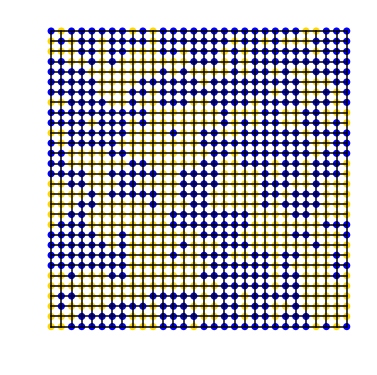

In [156]:
plot_configuration(np.reshape(np.array(configs[-1]), (N,N)))

In [157]:
def pca(X=np.array([]), no_dims=50):
    """
          Runs PCA on the NxD array X to reduce dimension
    """
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

In [158]:
PCA_coord = pca(configs, no_dims=2)

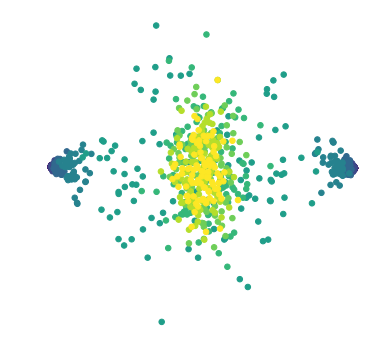

In [159]:
plt.scatter(PCA_coord[:,0], PCA_coord[:,1], 30, labels)
plt.axis('off')
plt.show()

### toy model

See the supplement of Carrasquilla & Melko for the details of this toy model

In [160]:
def get_parameters(eps):
    W = np.ones((3,N*N))/(N**2*(1+eps))
    W[1,:]=-1/(N**2*(1+eps))
    b = eps/(1+eps)*np.array([-1,-1,1])
    return W, b

In [161]:
W, b = get_parameters(0.1)

In [162]:
toy_y0 = np.dot(W, np.array(configs).T)
toy_x0 = np.mean(configs, axis=1)

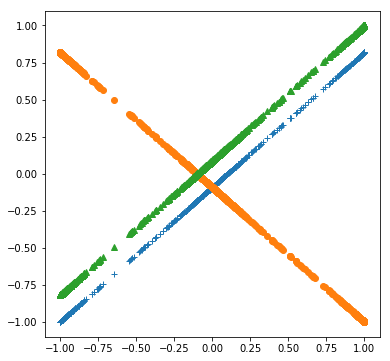

In [163]:
plt.plot(toy_x0, toy_y0[0]+b[0], '+')
plt.plot(toy_x0, toy_y0[1]+b[1], 'o')
plt.plot(toy_x0, toy_y0[2]+b[2], '^')
plt.show()

## toy dense network

In [164]:
# prepare data for training
# exclude temperatures between 2.1 and 2.4
T_low = 2.
T_high = 2.5
x = []
y = []
for i, label in enumerate(labels):
    if label < T_low:
        x.append(configs[i])
        y.append((1,0))
    if label > T_high:
        x.append(configs[i])
        y.append((0, 1))
x = np.array(x)
y = np.array(y)

In [165]:
# create model
model = Sequential()
model.add(Dense(3, input_dim=N**2, kernel_initializer='random_normal', activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, kernel_initializer='random_normal', activation='softmax', kernel_regularizer=regularizers.l2(0.0)))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [166]:
layer1 = model.get_layer(index=1)
W_init, b_init = layer1.get_weights()

In [167]:
init_y = np.dot(W_init.T, test_x.T)
init_x = np.mean(test_x, axis=1)

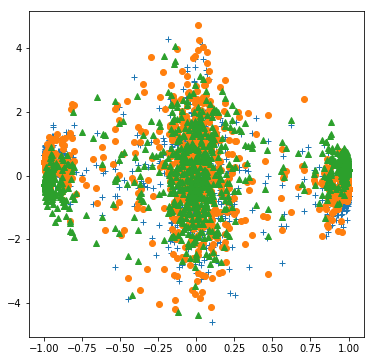

In [168]:
plt.plot(init_x, init_y[0]+b_init[0], '+')
plt.plot(init_x, init_y[1]+b_init[1], 'o')
plt.plot(init_x, init_y[2]+b_init[2], '^')
plt.show()

In [169]:
model.fit(x, y, epochs=50, batch_size=10,  verbose=0)

In [170]:
layer1 = model.get_layer(index=1)
W_trained, b_trained = layer1.get_weights()

In [171]:
trained_y = np.dot(W_trained.T, test_x.T)
trained_x = np.mean(test_x, axis=1)

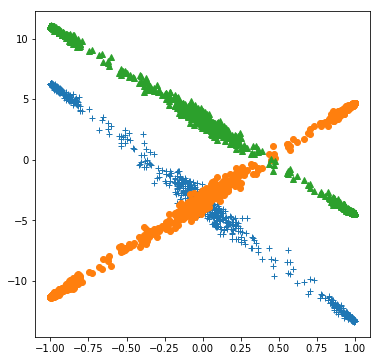

In [172]:
plt.plot(trained_x, trained_y[0]+b_trained[0], '+')
plt.plot(trained_x, trained_y[1]+b_trained[1], 'o')
plt.plot(trained_x, trained_y[2]+b_trained[2], '^')
plt.show()

In [173]:
prediction = model.predict(test_x)

In [174]:
Temps = list(np.sort(list(set(test_label))))
NT = len(Temps)
phase1 = np.zeros(NT)
phase2 = np.zeros(NT)
points = np.zeros(NT)
m = np.zeros(NT)
lastT = 0.
for i, T in enumerate(test_label):
    j = Temps.index(T)
    phase1[j]+=prediction[i:i+1, 0][0]
    phase2[j]+=prediction[i:i+1, 1][0]
    m[j] += abs(np.mean(test_x[i]))
    points[j]+=1.

for j in range(NT):
    phase1[j] /= points[j]
    phase2[j] /= points[j]
    m[j] /= points[j]

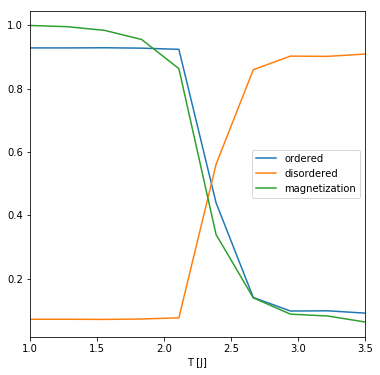

In [175]:
plt.plot(Temps, phase1, label='ordered')
plt.plot(Temps, phase2, label='disordered')
plt.plot(Temps, m, label='magnetization')
#plt.plot(Temp[1:], 0.1*dm, label='dm/dT [1/10]')
plt.legend()
plt.xlim(1,3.5)
plt.xlabel('T [J]')
plt.show()

In [176]:
# create bigger model
model2 = Sequential()
model2.add(Dense(16, input_dim=N**2, kernel_initializer='normal', activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(2, kernel_initializer='random_normal', activation='softmax'))

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [177]:
layer1_2 = model2.get_layer(index=1)
W_init2, b_init2 = layer1_2.get_weights()

In [178]:
init_y2 = np.dot(W_init2.T, test_x.T)
init_x2 = np.mean(test_x, axis=1)

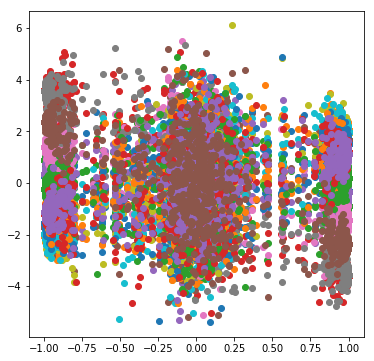

In [179]:
for i in range(np.shape(b_init2)[0]):
    plt.plot(init_x2, init_y2[i]+b_init2[i], 'o')
plt.show()

In [180]:
model2.fit(x, y, epochs=100, batch_size=32,  verbose=0)

In [181]:
layer1_2TB = model2.get_layer(index=1)
W_trained2B, b_trained2B = layer1_2TB.get_weights()

In [182]:
trained_y2B = np.dot(W_trained2B.T, test_x.T)
trained_x2B = np.mean(test_x, axis=1)

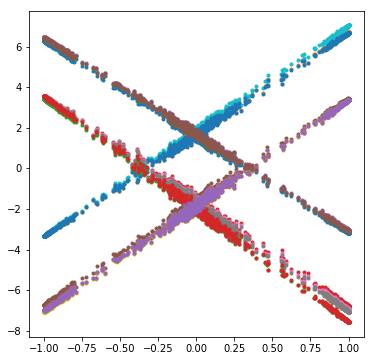

In [183]:
for i in range(np.shape(b_trained2B)[0]):
    plt.plot(trained_x2B, trained_y2B[i]+b_trained2B[i], '.')
plt.show()

In [184]:
prediction2 = model2.predict(test_x)

In [185]:
Temps = list(np.sort(list(set(test_label))))
NT = len(Temps)
phase1_2 = np.zeros(NT)
phase2_2 = np.zeros(NT)
points = np.zeros(NT)
m = np.zeros(NT)
lastT = 0.
for i, T in enumerate(test_label):
    j = Temps.index(T)
    phase1_2[j]+=prediction2[i:i+1, 0][0]
    phase2_2[j]+=prediction2[i:i+1, 1][0]
    m[j] += abs(np.mean(test_x[i]))
    points[j]+=1.

for j in range(NT):
    phase1_2[j] /= points[j]
    phase2_2[j] /= points[j]
    m[j] /= points[j]

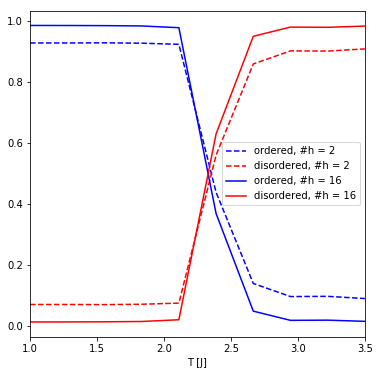

In [187]:
plt.plot(Temps, phase1, 'b--', label='ordered, #h = 2')
plt.plot(Temps, phase2, 'r--', label='disordered, #h = 2')
plt.plot(Temps, phase1_2, 'b', label='ordered, #h = 16')
plt.plot(Temps, phase2_2, 'r', label='disordered, #h = 16')
plt.legend()
plt.xlim(1,3.5)
plt.xlabel('T [J]')
plt.show()